# Numerical Optimization 2: More Constraints

This notebook uses the [NLopt](https://github.com/JuliaOpt/NLopt.jl) package which has well tested routines for constrained optimization.

(The `Optim` package has preliminary code for similar functionality, see the IPNewton section of the documentation.)

## Load Packages and Extra Functions

In [1]:
using Dates, NLopt

include("printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

We use the algorithm `LN_COBYLA` which does not require us to code up the derivatives, but can still handle restrictions.

In [3]:
function lossfun(p,grad,A)    #grad is never used, but must be in function def
    (x,y) = (p[1],p[2])       #A could be data or other things that the function depends on 
    L     = (x-2)^2 + (4*y+3)^2
    return L
end

lossfun (generic function with 1 method)

In [4]:
nx = 2*41
ny = 2*61
x = range(1,stop=5,length=nx)
y = range(-1,stop=0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny
    loss2d[i,j] = lossfun([x[i];y[j]],[],0)
end

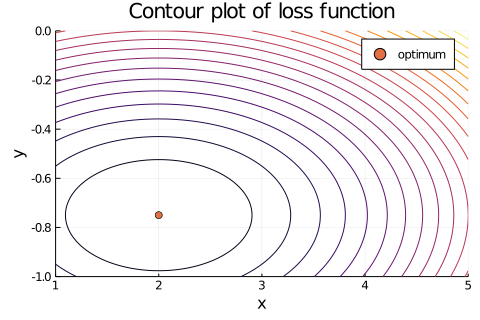

In [5]:
p1 = contour( x,y,loss2d',               #notice: loss2d'
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y" )
scatter!([2],[-0.75],label="optimum",legend=true)
display(p1)

Tell NLopt what to minimize as follows

```
min_objective!(opt,(p,g)->lossfun(p,g,0))
```

The `p` will be the parameters (over which we optimize), `g` the gradient (which is actually not used but must be there in the call) and `0` corresponds to the extra argument `A` in the definition of `lossfun`. We here use `A=0`, but in other contexts it could clearly be something else.

In [6]:
opt = Opt(:LN_COBYLA, 2)                  #unconstrained minimization
lower_bounds!(opt,[-100,-100])            #LN_COBYLA seems to need some restrictions 
min_objective!(opt,(p,g)->lossfun(p,g,0))
xtol_rel!(opt,1e-8)                       #set convergence tolerance to a reasonable number  

(minf,minx,ret) = optimize(opt,[0.0,0.0])
println("minimum at $minx and $ret")

minimum at [1.9999956432004986, -0.7499993454487518] and XTOL_REACHED


# Optimization with Bounds on the Parameters

The next few cells illustrate how to impose bounds like $a \leq x$ and $y \leq b$.

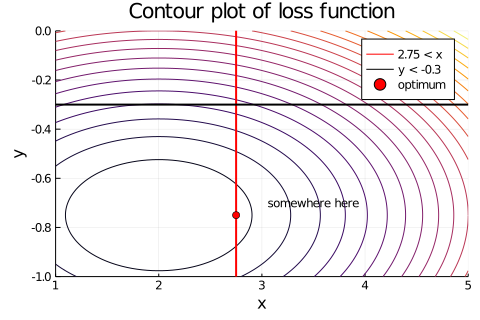

In [7]:
p1 = contour( x,y,loss2d',
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              annotation = (3.5,-0.7,text("somewhere here",8)) )
plot!([2.75,2.75],[-1,0.5],linecolor=:red,linewidth=2,label="2.75 < x",legend=true)
plot!([1,5],[-0.3,-0.3],linecolor=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.75],markercolor=:red,label="optimum")
display(p1)

In [8]:
opt = Opt(:LN_COBYLA, 2)               #bounds on the parameters
lower_bounds!(opt,[2.75, -Inf])
upper_bounds!(opt,[Inf, -0.3])
min_objective!(opt,(p,g)->lossfun(p,g,0))
xtol_rel!(opt,1e-8)

(minf,minx,ret) = optimize(opt,[3.0, -0.5])
println("minimum at $minx and $ret")

minimum at [2.75, -0.7500000009574268] and XTOL_REACHED


# Optimization with Equality Constraints

We now impose the constraint that $x+2y-3=0.$

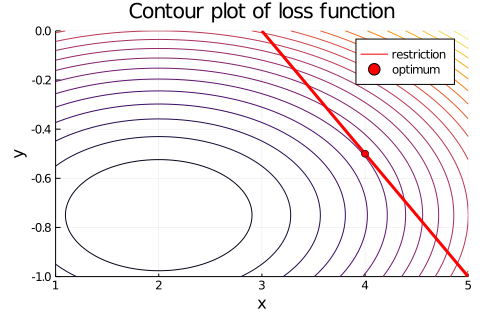

In [9]:
p1 = contour(x,y,loss2d',
             xlims = (1,5),
             ylims = (-1,0),
             legend = false,
             levels = 21, 
             title = "Contour plot of loss function",
             xlabel = "x",
             ylabel = "y" )
plot!(3 .- 2*y,y,linecolor=:red,linewidth=3,label="restriction",legend=true)
scatter!([4],[-0.5],markercolor=:red,label="optimum")
display(p1)

In [10]:
function EqConstrfun(p,grad)   #equality constraint
    (x,y) = (p[1],p[2])
    c  = x + 2*y - 3
    return c
end

opt = Opt(:LN_COBYLA, 2)
equality_constraint!(opt,(p,g) -> EqConstrfun(p,g))
min_objective!(opt,(p,g)->lossfun(p,g,0))
xtol_rel!(opt,1e-8)

(minf,minx,ret) = optimize(opt,[3.0, 0.0])
println("minimum at $minx and $ret")

minimum at [3.999999990948508, -0.4999999954742538] and XTOL_REACHED


# Optimization with Inequality Constraints

We now impose the constraint that $y \le -(x-4)^2$.

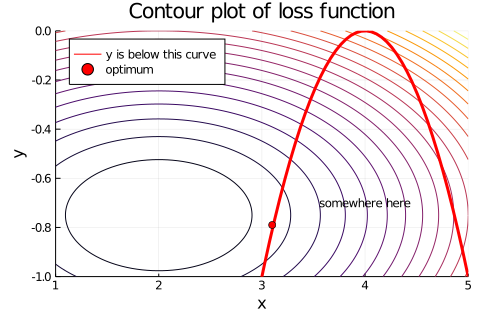

In [11]:
yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour( x,y,loss2d',
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              xlims = (1,5),
              ylims = (-1,0),
              annotation = (4.0,-0.7,text("somewhere here",8)) )
plot!(x,yRestriction,linecolor=:red,linewidth=3,label="y is below this curve",legend=:topleft)
scatter!([3.1],[-0.79],markercolor=:red,label="optimum")
display(p1)

In [12]:
function IneqConstrfun(p,grad)     #inequality restriction, <=
    (x,y) = (p[1],p[2])
    r  = y + (x-4)^2
  return r
end

opt = Opt(:LN_COBYLA, 2)
inequality_constraint!(opt,(p,g) -> IneqConstrfun(p,g))
min_objective!(opt,(p,g)->lossfun(p,g,0))
xtol_rel!(opt,1e-8)

(minf,minx,ret) = optimize(opt,[4.0, -0.1])
println("minimum at $minx and $ret")

minimum at [3.1116826377923497, -0.7891077359995573] and XTOL_REACHED
